[1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0
 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1
 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1
 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1]
0.10454545454545454


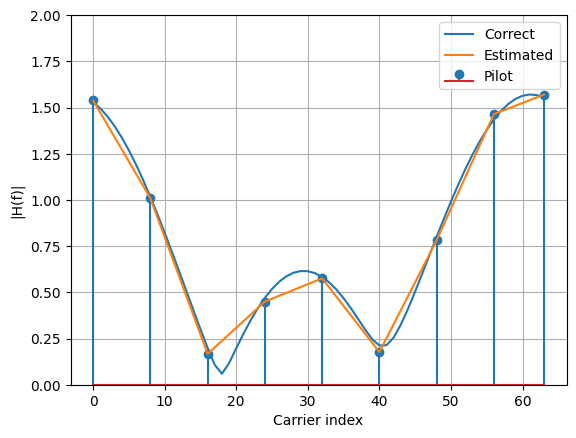

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf,erfc
import scipy
#number of subcarrier
K = 64
#cyclic prefix
CP = K//4
#pilot
P = 8
M = 4 #bits per symbol (16QAM)
Channel_response = np.array([0.5, 0.5, 0.5 - 0.3j])
H_exact = np.fft.fft(Channel_response, K)

SNRdB = 25
pilotValue = 3 + 3j
allCarriers = np.arange(K)
pilotCarriers = allCarriers[::K//P]

pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])

P = P+1

# Carrier mang thông tin
dataCarriers = np.delete(allCarriers, pilotCarriers)

totalbit_OFDM = len(dataCarriers)*M

bit_sequence = np.random.binomial(n=1, p=0.5, size=(totalbit_OFDM, ))
# print(bit_sequence)

mapping = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

#mapping 16QAM
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping[B]
                # plt.plot(Q.real, Q.imag, 'bo')
                # plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
demapping_table = {v : k for k, v in mapping.items()}
# allCarriers
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
#  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]

# pilotCarriers
# [ 0  8 16 24 32 40 48 56 63]

# dataCarriers
# [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
#  28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
#  55 57 58 59 60 61 62]

# plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'go', label='pilot')
# plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')



# plt.plot(allCarriers, abs(H_exact))

# print(bit_sequence[:50])

#serial to paralell
def S_P(bits):
  return bits.reshape(len(dataCarriers), M)
bits_SP = S_P(bit_sequence)
# print(bits_SP)
# print(len(bits_SP))
def Mapping(bits):
    return np.array([mapping[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
# print (bits_SP[:5,:])
# print (QAM[:5])
# [[1 0 1 1]
#  [1 1 1 1]
#  [1 0 0 0]
#  [1 0 0 0]
#  [1 1 1 0]]
# [3.+1.j 1.+1.j 3.-3.j 3.-3.j 1.+3.j]
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex)
    symbol[pilotCarriers] = pilotValue
    symbol[dataCarriers] = QAM_payload
    return symbol
OFDM_data = OFDM_symbol(QAM)
#print(OFDM_data)
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)

# Number of OFDM samples in time-domain before CP:  64
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]
    return np.hstack([cp, OFDM_time])
OFDM_withCP = addCP(OFDM_time)
#print(OFDM_withCP)


def channel(signal):
    Y = np.convolve(signal, Channel_response)
    signal_power = np.mean(abs(Y**2))

    noise_power = signal_power * 10**(-SNRdB/10)
    noise = np.sqrt(noise_power/2) * (np.random.randn(*Y.shape)+1j*np.random.randn(*Y.shape))
    return Y + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
# plt.figure(figsize=(8,2))
# plt.plot(abs(OFDM_TX), label='TX')
# plt.plot(abs(OFDM_RX), label='RX')
# plt.legend(fontsize=10)
# plt.xlabel('Time')
# plt.ylabel('x(t)')
# plt.grid(True)
#loại bỏ cyclic prefix
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)
#đưa về miền tần số
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
#print(OFDM_demod)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]
    H_est_at_pilots = pilots / pilotValue # Channel gain ước lượng ở sóng mang chứa pilot

    # Nội suy ra H_estimate từ H_est_pilot

    H_est_abs = scipy.interpolate.interp1d(pilotCarriers, abs(H_est_at_pilots), kind='linear')(allCarriers)
    H_est_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_est_at_pilots), kind='linear')(allCarriers)
    H_est = H_est_abs * np.exp(1j*H_est_phase)

    plt.plot(allCarriers, abs(H_exact), label='Correct')
    plt.stem(pilotCarriers, abs(H_est_at_pilots), label='Pilot')
    plt.plot(allCarriers, abs(H_est), label='Estimated')
    plt.grid(True)
    plt.xlabel('Carrier index'); plt.ylabel('|H(f)|')
    plt.legend(fontsize=10)
    plt.ylim(0,2)

    return H_est
H_est = channelEstimate(OFDM_demod)

#Bù
def equalize(OFDM_demod, H_est):
    return OFDM_demod / H_est
equalized_H_est = equalize(OFDM_demod, H_est)

def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_H_est)
# plt.plot(QAM_est.real, QAM_est.imag, 'bo')

def demapping(QAM):
  constel = np.array([x for x in demapping_table.keys()])

  #khoang cach tu diem nhan duoc den diem constel gan nhat co the
  dis = abs(QAM.reshape((-1, 1)) - constel.reshape((1, -1)))
  constel_index = dis.argmin(axis = 1)
  HDecision = constel[constel_index]
  return np.vstack([demapping_table[C] for C in HDecision]), HDecision

PS_est, HDecision = demapping(QAM_est)
# for qam, hard in zip(QAM_est, HDecision):
#     plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
#     plt.plot(HDecision.real, HDecision.imag, 'ro')

def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)
print(bits_est)

BER = np.mean(bit_sequence != bits_est)
print(BER)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc
import scipy

# number of subcarriers
K = 64
# cyclic prefix
CP = K // 4
# pilot
P = 8
M = 4  # bits per symbol (16QAM)
Chan_gain = np.array([1])
H_exact = np.fft.fft(Chan_gain, K)


SNRdB = np.linspace(10, 20)  # SNR range
pilotValue = 3 + 3j
allCarriers = np.arange(K)
pilotCarriers = allCarriers[::K // P]
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P + 1

# Carrier mang thông tin
dataCarriers = np.delete(allCarriers, pilotCarriers)
totalbit_OFDM = len(dataCarriers) * M
# print(totalbit_OFDM)
bit_sequence = np.random.binomial(n=1, p=0.5, size=(totalbit_OFDM, ))

mapping = {
    (0, 0, 0, 0): -3-3j,
    (0, 0, 0, 1): -3-1j,
    (0, 0, 1, 0): -3+3j,
    (0, 0, 1, 1): -3+1j,
    (0, 1, 0, 0): -1-3j,
    (0, 1, 0, 1): -1-1j,
    (0, 1, 1, 0): -1+3j,
    (0, 1, 1, 1): -1+1j,
    (1, 0, 0, 0): 3-3j,
    (1, 0, 0, 1): 3-1j,
    (1, 0, 1, 0): 3+3j,
    (1, 0, 1, 1): 3+1j,
    (1, 1, 0, 0): 1-3j,
    (1, 1, 0, 1): 1-1j,
    (1, 1, 1, 0): 1+3j,
    (1, 1, 1, 1): 1+1j
}

demapping_table = {v: k for k, v in mapping.items()}

def S_P(bits):
    return bits.reshape(len(dataCarriers), M)

bits_SP = S_P(bit_sequence)


def Mapping(bits):
    return np.array([mapping[tuple(b)] for b in bits])

QAM = Mapping(bits_SP)

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex)
    symbol[pilotCarriers] = pilotValue
    symbol[dataCarriers] = QAM_payload
    return symbol

OFDM_data = OFDM_symbol(QAM)

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

OFDM_time = IDFT(OFDM_data)

print(OFDM_time)
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]
    return np.hstack([cp, OFDM_time])

OFDM_withCP = addCP(OFDM_time)
print(OFDM_withCP)
def channel(signal, snr_db):
    Y = np.convolve(signal, Chan_gain)[:len(signal)]
    signal_power = np.mean(abs(Y**2))
    noise_power = signal_power * 10**(-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(*Y.shape) + 1j*np.random.randn(*Y.shape))
    return Y + noise

def removeCP(signal):
    return signal[CP:(CP + K)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]
    H_est_at_pilots = pilots / pilotValue

    H_est_abs = scipy.interpolate.interp1d(pilotCarriers, abs(H_est_at_pilots), kind='linear')(allCarriers)
    H_est_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_est_at_pilots), kind='linear')(allCarriers)
    H_est = H_est_abs * np.exp(1j * H_est_phase)

    return H_est

def equalize(OFDM_demod, H_est):
    return OFDM_demod / H_est

def get_payload(equalized):
    return equalized[dataCarriers]

def demapping(QAM):
    constel = np.array([x for x in demapping_table.keys()])
    dis = abs(QAM.reshape((-1, 1)) - constel.reshape((1, -1)))
    constel_index = dis.argmin(axis=1)
    HDecision = constel[constel_index]
    return np.vstack([demapping_table[C] for C in HDecision]), HDecision

def PS(bits):
    return bits.reshape((-1,))

BER = []

for snr_db in SNRdB:
  A = np.zeros(100000)
  for i in range(1, 100000):
      OFDM_RX = channel(OFDM_withCP, snr_db)
      OFDM_RX_noCP = removeCP(OFDM_RX)
      OFDM_demod = DFT(OFDM_RX_noCP)
      H_est = channelEstimate(OFDM_demod)
      equalized_H_est = equalize(OFDM_demod, H_est)
      QAM_est = get_payload(equalized_H_est)
      PS_est, HDecision = demapping(QAM_est)
      bits_est = PS(PS_est)
      A[i] = np.mean(bit_sequence != bits_est)
  BER.append(np.mean(A))
# for qam, hard in zip(QAM_est, HDecision):
#     plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
#     plt.plot(HDecision.real, HDecision.imag, 'ro')


# plt.figure(figsize=(8, 4))
# plt.plot(SNRdB, BER, 'bo-')
# plt.semilogy()
# plt.xlabel('SNR (dB)')
# plt.ylabel('BER')
# plt.grid(True)
# plt.show()

[ 0.40625   -0.0625j      0.18466973+0.34011644j  0.10148578-0.22574769j
  0.40195995-0.32511307j  0.2510665 +0.00317888j -0.12485221-0.08126368j
 -0.09974625+0.15630872j  0.10040459-0.05141749j  0.5517767 +0.21875j
  0.07997695-0.17074431j  0.14329931+0.42501729j -0.31735788-0.23953537j
 -0.09765317+0.27917572j  0.07945777-0.03243735j -0.20227867-0.17726873j
  0.62267292-0.15420432j  0.53125   -0.0625j      0.12828221+0.25294179j
  0.27735009+0.62295699j  0.22262158-0.31838599j  0.5225893 -0.01718955j
  0.42954853-0.49859157j  0.00657414+0.23438194j -0.29727475-0.24712209j
  0.45580583+0.90310922j  0.2170561 -0.05807455j -0.03730687-0.15121375j
  0.3595513 +0.21834513j -0.33535122-0.46231017j -0.35593233-0.03746575j
 -0.05559085+0.11155751j -0.3465659 -0.30542427j  0.21875   +0.375j
 -0.36333447-0.15643405j -0.06364936+0.12007782j -0.26037034+0.36967108j
  0.22304515-0.17995557j -0.07109079+0.33947698j -0.21597073+0.41204172j
 -0.47018811-0.02164768j  0.1982233 +0.21875j     0.0655429

330
[ 5.93750000e-01+0.21875j    -2.82197516e-01+0.57933748j
 -1.64675746e-01+0.13386753j  7.26160260e-01+0.68016034j
  7.79508777e-01+0.25049668j  5.56923117e-01+0.78600255j
 -1.36529086e-01+0.47675459j -6.11171958e-01-0.41384031j
  1.26570392e-01+1.18815048j  7.07545788e-01+0.07274421j
 -8.00422620e-02-0.25014876j  1.06539644e-01-0.30794396j
 -4.90335304e-01-0.17537946j -3.69062464e-01+0.07431931j
  2.41948511e-01+0.01632023j  1.25482681e+00+0.40338241j
 -4.37500000e-01+0.5625j     -4.17447749e-01+0.02848291j
  1.92164067e-01+0.13402575j -1.25548793e+00+0.05797137j
  2.67514932e-01+0.26602193j  3.52398693e-01-0.64061275j
 -9.31684484e-02-0.0056511j  -1.12860178e+00-0.68117128j
  6.27871347e-01+0.0435437j   2.80879102e-01-0.3412754j
  2.11290034e-01-0.69034612j  6.37267715e-01-0.33071574j
  5.02490153e-01+0.38559525j  7.04200863e-01+0.32186922j
 -6.93097409e-01+0.18646055j -6.03019421e-01+0.89445799j
  1.28125000e+00-0.03125j    -1.90449608e-01-0.47795756j
  3.86108991e-01+0.94416614j

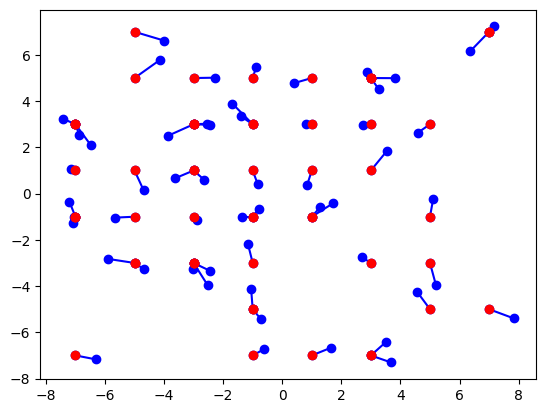

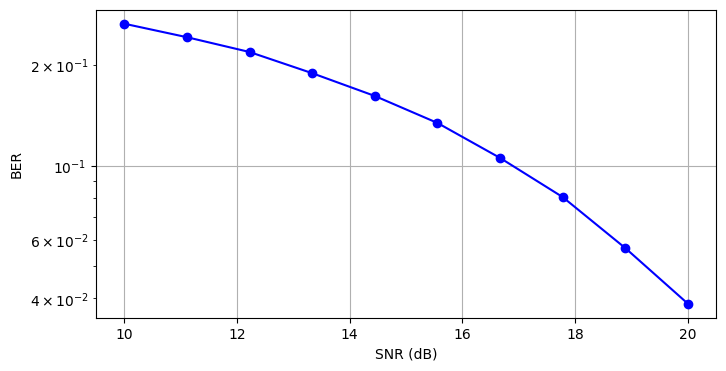

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc
import scipy
import itertools
# number of subcarriers
K = 64
# cyclic prefix
CP = K // 4
# pilot
P = 8
M = 6  # bits per symbol (16QAM)
Channel_response = np.array([1])
H_exact = np.fft.fft(Channel_response, K)

SNRdB = np.linspace(10, 20, num=10)  # SNR range, thêm num=10 để tạo mảng có 10 giá trị
pilotValue = 3 + 3j
allCarriers = np.arange(K)
pilotCarriers = allCarriers[::K // P]
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P + 1

# Carrier mang thông tin
dataCarriers = np.delete(allCarriers, pilotCarriers)
totalbit_OFDM = len(dataCarriers) * M
print(totalbit_OFDM)
bit_sequence = np.random.binomial(n=1, p=0.5, size=(totalbit_OFDM, ))

# mapping = {
#     (0, 0, 0, 0): -3-3j,
#     (0, 0, 0, 1): -3-1j,
#     (0, 0, 1, 0): -3+3j,
#     (0, 0, 1, 1): -3+1j,
#     (0, 1, 0, 0): -1-3j,
#     (0, 1, 0, 1): -1-1j,
#     (0, 1, 1, 0): -1+3j,
#     (0, 1, 1, 1): -1+1j,
#     (1, 0, 0, 0): 3-3j,
#     (1, 0, 0, 1): 3-1j,
#     (1, 0, 1, 0): 3+3j,
#     (1, 0, 1, 1): 3+1j,
#     (1, 1, 0, 0): 1-3j,
#     (1, 1, 0, 1): 1-1j,
#     (1, 1, 1, 0): 1+3j,
#     (1, 1, 1, 1): 1+1j
# }




def qam_mapping(M):
    n = int(np.log2(M))
    mapping = {}
    for i, bits in enumerate(itertools.product([0, 1], repeat=n)):
        I = 2 * sum([bit * (2 ** (n // 2 - j - 1)) for j, bit in enumerate(bits[:n // 2])]) - (2 ** (n // 2)) + 1
        Q = 2 * sum([bit * (2 ** (n // 2 - j - 1)) for j, bit in enumerate(bits[n // 2:])]) - (2 ** (n // 2)) + 1
        mapping[bits] = I + 1j * Q
    return mapping
mapping = qam_mapping(2**M)
demapping_table = {v: k for k, v in mapping.items()}

def S_P(bits):
    return bits.reshape(len(dataCarriers), M)

bits_SP = S_P(bit_sequence)

def Mapping(bits):
    return np.array([mapping[tuple(b)] for b in bits])

QAM = Mapping(bits_SP)

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex)
    symbol[pilotCarriers] = pilotValue
    symbol[dataCarriers] = QAM_payload
    return symbol

OFDM_data = OFDM_symbol(QAM)

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

OFDM_time = IDFT(OFDM_data)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]
    return np.hstack([cp, OFDM_time])

OFDM_withCP = addCP(OFDM_time)
print(OFDM_withCP)

def channel(signal, snr_db):
    Y = np.convolve(signal, Channel_response)[:len(signal)]
    signal_power = np.mean(abs(Y**2))
    noise_power = signal_power * 10**(-snr_db / 10)
    noise = np.sqrt(noise_power/2) * (np.random.randn(*Y.shape) + 1j*np.random.randn(*Y.shape))
    return Y + noise

def removeCP(signal):
    return signal[CP:(CP + K)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]
    H_est_at_pilots = pilots / pilotValue

    H_est_abs = scipy.interpolate.interp1d(pilotCarriers, abs(H_est_at_pilots), kind='linear')(allCarriers)
    H_est_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_est_at_pilots), kind='linear')(allCarriers)
    H_est = H_est_abs * np.exp(1j * H_est_phase)

    return H_est

def equalize(OFDM_demod, H_est):
    return OFDM_demod / H_est

def get_payload(equalized):
    return equalized[dataCarriers]

def demapping(QAM):
    constel = np.array([x for x in demapping_table.keys()])
    dis = abs(QAM.reshape((-1, 1)) - constel.reshape((1, -1)))
    constel_index = dis.argmin(axis=1)
    HDecision = constel[constel_index]
    return np.vstack([demapping_table[C] for C in HDecision]), HDecision

def PS(bits):
    return bits.reshape((-1,))

BER = []

for snr_db in SNRdB:
    A = np.zeros(1000)
    for i in range(1000):
        OFDM_RX = channel(OFDM_withCP, snr_db)
        OFDM_RX_noCP = removeCP(OFDM_RX)
        OFDM_demod = DFT(OFDM_RX_noCP)
        H_est = channelEstimate(OFDM_demod)
        equalized_H_est = equalize(OFDM_demod, H_est)
        QAM_est = get_payload(equalized_H_est)
        PS_est, HDecision = demapping(QAM_est)
        bits_est = PS(PS_est)
        A[i] = np.mean(bit_sequence != bits_est)
    BER.append(np.mean(A))

for qam, hard in zip(QAM_est, HDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
plt.plot(HDecision.real, HDecision.imag, 'ro')

plt.figure(figsize=(8, 4))
plt.plot(SNRdB, BER, 'bo-')
plt.semilogy()
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.show()
